### TLDR: Sine activation function is better than ReLU for reconstructing images

::: {layout-ncol=2}
![Reconstruction from ReLU](mlp_dog.png)

![Reconstruction from Sine](mlp_sin_dog.png)
:::

### Animation of the training process
::: {layout-ncol=2}
![Reconstruction from ReLU](mlp.gif)

![Reconstruction from Sine](mlp_sin.gif)
:::



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
!wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2023-04-27 17:21:53--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 108.138.128.23, 108.138.128.8, 108.138.128.34, ...
Connecting to segment-anything.com (segment-anything.com)|108.138.128.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K   400KB/s    in 0.5s    

2023-04-27 17:21:55 (400 KB/s) - ‘dog.jpg’ saved [221810/221810]



In [2]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")


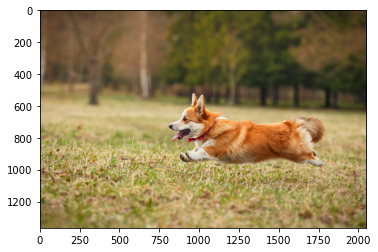

In [3]:
plt.imshow(img.permute(1, 2, 0))

In [4]:
# Normalize the image
img = img / 255.0

In [5]:
img.shape


torch.Size([3, 1365, 2048])

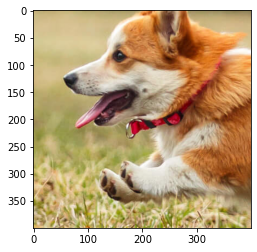

In [6]:
# Take a random 224x224 crop of the image
crop = torchvision.transforms.functional.crop(img, 600, 750, 400, 400)


# Plot the crop
plt.imshow(crop.permute(1, 2, 0))

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape

# Create a 2D grid of (x,y) coordinates
x_coords = torch.arange(width).repeat(height, 1)
y_coords = torch.arange(height).repeat(width, 1).t()
x_coords = x_coords.reshape(-1)
y_coords = y_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([x_coords, y_coords], dim=1).float()

# Move X to GPU if available
X = X.to(device)

In [9]:
num_xy = height * width
num_xy

160000

In [10]:
X.shape, X

(torch.Size([160000, 2]),
 tensor([[  0.,   0.],
         [  1.,   0.],
         [  2.,   0.],
         ...,
         [397., 399.],
         [398., 399.],
         [399., 399.]], device='cuda:0'))

In [11]:
# Extract pixel values from image tensor
pixel_values = crop.reshape(num_channels, -1).float().to(device)

# Transpose the pixel values to be (num_xy, num_channels)
pixel_values = pixel_values.transpose(0, 1)

y = pixel_values.to(device)

In [12]:
# Create a MLP with 5 hidden layers with 256 neurons each and ReLU activations.
# Input is (x, y) and output is (r, g, b)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return self.fc6(x)

In [13]:
# Training loop function to train the model
# X: (num_xy, 2) tensor of (x, y) coordinates
# y: (num_xy, 3) tensor of (r, g, b) pixel values
# model: MLP model
# lr: learning rate
# epochs: number of epochs to train for
# bs: batch size
# print_every: print loss every print_every epochs
# Logs losses
# Saves the prediction frmo model every print_every epochs

def train(X, y, model, lr=0.01, epochs=1000, bs=1000, print_every=100):
    losses = []
    imgs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        # Get a random batch of (x, y) coordinates
        idxs = torch.randperm(num_xy)[:bs]
        batch_X = X[idxs]
        batch_y = y[idxs]

        # Predict the (r, g, b) values
        pred_y = model(batch_X)

        # Compute the loss
        loss = criterion(pred_y, batch_y)

        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Print loss every print_every epochs
        if epoch % print_every == 0:
            print(f"Epoch {epoch} loss: {loss.item()}")
            with torch.no_grad():
                # Predict the (r, g, b) values
                pred_y = model(X)

                # Reshape the predictions to be (3, height, width)
                pred_y = pred_y.transpose(0, 1).reshape(num_channels, height, width)
                imgs.append(pred_y.permute(1, 2, 0).detach().cpu())
                
    return losses, imgs

In [14]:
m1 = MLP()
m1 = m1.to(device)
losses_mlp, imgs = train(X, y, m1, lr=0.001, epochs=4000, bs=2000, print_every=100)

Epoch 0 loss: 1.5234602689743042
Epoch 100 loss: 0.0640626773238182
Epoch 200 loss: 0.04388527199625969
Epoch 300 loss: 0.03277464583516121
Epoch 400 loss: 0.03183111175894737
Epoch 500 loss: 0.02485758438706398
Epoch 600 loss: 0.023289738222956657
Epoch 700 loss: 0.024606380611658096
Epoch 800 loss: 0.023782318457961082
Epoch 900 loss: 0.026350615546107292
Epoch 1000 loss: 0.025088826194405556
Epoch 1100 loss: 0.023389095440506935
Epoch 1200 loss: 0.02370390295982361
Epoch 1300 loss: 0.023111725226044655
Epoch 1400 loss: 0.023864751681685448
Epoch 1500 loss: 0.021725382655858994
Epoch 1600 loss: 0.021787280216813087
Epoch 1700 loss: 0.021760988980531693
Epoch 1800 loss: 0.021614212542772293
Epoch 1900 loss: 0.020562106743454933
Epoch 2000 loss: 0.019880816340446472
Epoch 2100 loss: 0.01901845820248127
Epoch 2200 loss: 0.018372364342212677
Epoch 2300 loss: 0.01828525774180889
Epoch 2400 loss: 0.018451901152729988
Epoch 2500 loss: 0.01738181710243225
Epoch 2600 loss: 0.01698809117078781

In [15]:
def plot_image(model, name=None):
    # Predict the (r, g, b) values
    pred_y = model(X)

    # Reshape the predictions to be (3, height, width)
    pred_y = pred_y.transpose(0, 1).reshape(num_channels, height, width)

    # plot the image
    plt.imshow(pred_y.permute(1, 2, 0).detach().cpu())
    if name:
        plt.savefig(name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


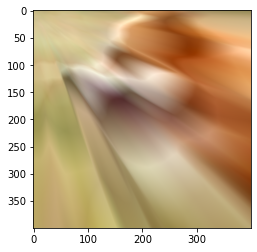

In [16]:
plot_image(m1, "mlp_dog.png")

In [17]:
# Create the animation from imgs and save it as a gif

import imageio
imageio.mimsave('mlp.gif', imgs, fps=10)

Lossy conversion from float32 to uint8. Range [-13.466928482055664, 2.713646650314331]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.18658676743507385, 1.3069090843200684]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to su

![](mlp.gif)

In [18]:
# Create a MLP with 5 hidden layers with 256 neurons each and sine activations.
# Input is (x, y) and output is (r, g, b)

class MLP_sin(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, 3)

    def forward(self, x):
        x = torch.sin(self.fc1(x))
        x = torch.sin(self.fc2(x))
        x = torch.sin(self.fc3(x))
        x = torch.sin(self.fc4(x))
        x = torch.sin(self.fc5(x))
        return self.fc6(x)

In [19]:
m2 = MLP_sin()
m2 = m2.to(device)
losses_mlp_sin, imgs = train(X, y, m2, lr=0.001, epochs=4000, bs=1000, print_every=100)

Epoch 0 loss: 0.40150442719459534
Epoch 100 loss: 0.03298206627368927
Epoch 200 loss: 0.033279214054346085
Epoch 300 loss: 0.03175220638513565
Epoch 400 loss: 0.03205806389451027
Epoch 500 loss: 0.03196191042661667
Epoch 600 loss: 0.02972976118326187
Epoch 700 loss: 0.029925711452960968
Epoch 800 loss: 0.02968132309615612
Epoch 900 loss: 0.028653116896748543
Epoch 1000 loss: 0.02474542148411274
Epoch 1100 loss: 0.020879685878753662
Epoch 1200 loss: 0.019819265231490135
Epoch 1300 loss: 0.016965048387646675
Epoch 1400 loss: 0.013934656977653503
Epoch 1500 loss: 0.011689499020576477
Epoch 1600 loss: 0.010081701911985874
Epoch 1700 loss: 0.007140354719012976
Epoch 1800 loss: 0.006480662152171135
Epoch 1900 loss: 0.005266484338790178
Epoch 2000 loss: 0.004757172428071499
Epoch 2100 loss: 0.003453798359259963
Epoch 2200 loss: 0.0032651633955538273
Epoch 2300 loss: 0.0028410402592271566
Epoch 2400 loss: 0.0026403532829135656
Epoch 2500 loss: 0.0019292739452794194
Epoch 2600 loss: 0.002136741

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


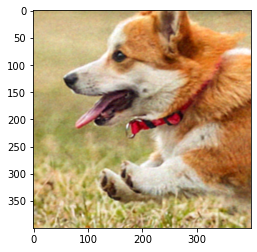

In [20]:
plot_image(m2, "mlp_sin_dog.png")

In [21]:
imageio.mimsave('mlp_sin.gif', imgs, fps=10)

Lossy conversion from float32 to uint8. Range [-0.1441832184791565, 0.3080734610557556]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy convers

![](mlp_sin.gif)

In [23]:
# Audio
!wget https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav

--2023-04-28 14:24:10--  https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav
Resolving www.vincentsitzmann.com (www.vincentsitzmann.com)... 185.199.111.153, 185.199.108.153, 185.199.110.153, ...
Connecting to www.vincentsitzmann.com (www.vincentsitzmann.com)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1232886 (1.2M) [audio/wav]
Saving to: ‘gt_bach.wav.3’

gt_bach.wav.3       100%[===================>]   1.17M  --.-KB/s    in 0.06s   

2023-04-28 14:24:10 (19.7 MB/s) - ‘gt_bach.wav.3’ saved [1232886/1232886]



In [93]:
# CLear CUDA cache
torch.cuda.empty_cache()

In [94]:
from IPython.display import Audio
Audio('gt_bach.wav')

In [95]:
# Read the audio file
import torchaudio
audio, sr = torchaudio.load('gt_bach.wav')


In [96]:
sr

44100

In [97]:
audio.shape
audio = audio[0]
audio = audio.to(device)

In [98]:
# use last 2 seconds of audio
audio = audio[-2 * sr:]
X = torch.arange(0, len(audio)).unsqueeze(1).float().to(device)

# Rescale X between -10 and 10
X = X / X.max() * 20 - 10
X.min(), X.max()


(tensor(-10., device='cuda:0'), tensor(10., device='cuda:0'))

In [99]:
X.shape, audio.shape, X

(torch.Size([88200, 1]),
 torch.Size([88200]),
 tensor([[-10.0000],
         [ -9.9998],
         [ -9.9995],
         ...,
         [  9.9995],
         [  9.9998],
         [ 10.0000]], device='cuda:0'))

In [100]:
Audio(audio.cpu(), rate=sr)

In [101]:
class SinActivation(torch.nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        return
    def forward(self, x):
        return torch.sin(x)
    

class SinActivation30(torch.nn.Module):
    def __init__(self):
        super(SinActivation30, self).__init__()
        return
    def forward(self, x):
        return torch.sin(30*x)

In [102]:
import torch.nn as nn

def create_mlp(n, m, f):
    """
    n: number of hidden layers
    m: number of neurons in each hidden layer
    f: activation function
    ---
    Weighing initialization: 
    uniform distribution between -30/input_dim and 30/input_dim for first layer
    -sqrt(6/input_dim) and sqrt(6/input_dim) for the rest

    Weight init is done in the forward pass
    """

    layers = []
    layer1 = nn.Linear(1, m)
    torch.nn.init.uniform_(layer1.weight, a=-1/1, b=1/1)
    #torch.nn.init.uniform_(layer1.bias, a=-1/1, b=1/1)
    layers.append(layer1)
    layers.append(SinActivation30())
    for i in range(n):
        layer_i = nn.Linear(m, m)
        # Uniform distribution between -sqrt(6/input_dim) and sqrt(6/input_dim)
        torch.nn.init.uniform_(layer_i.weight, a=-np.sqrt(6/m), b=np.sqrt(6/m))
        torch.nn.init.uniform_(layer_i.bias, a=-np.sqrt(6/m), b=np.sqrt(6/m))
        layers.append(layer_i)
        layers.append(f)
    layers.append(nn.Linear(m, 1))

    return nn.Sequential(*layers)


In [103]:
mlp_audio_sin_5_256 = create_mlp(5, 256, SinActivation()).to(device)
#mlp_audio_sin_8_512 = create_mlp(8, 512, SinActivation()).to(device)
#mlp_audio_sin_3_128 = create_mlp(3, 128, SinActivation()).to(device)

In [104]:
mlp_audio_sin_5_128

NameError: name 'mlp_audio_sin_5_128' is not defined

In [105]:
def train_audio(X, y, model, lr=0.01, epochs=1000, bs=1000, print_every=100):
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        num_rows = X.shape[0]
        idx = torch.randperm(num_rows)[:bs]
        batch_X = X[idx]
        batch_y = y[idx]
        pred_y = model(batch_X)

        # Compute the loss
        loss = criterion(pred_y, batch_y)

        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Print loss every print_every epochs
        if epoch % print_every == 0:
            print(f"Epoch {epoch} loss: {loss.item()}")

    return losses

In [106]:
#losses_mlp_sin_3_128 = train_audio(X, audio, mlp_audio_sin_3_128, lr=0.0001,
#                                    epochs=5000, bs=len(X)//2, print_every=100)

losses_mlp_sin_5_256 = train_audio(X, audio, mlp_audio_sin_5_256, lr=0.0001,
                                    epochs=5000, bs=len(X)//2, print_every=100)

Epoch 0 loss: 0.210729718208313


OutOfMemoryError: CUDA out of memory. Tried to allocate 7.25 GiB (GPU 0; 79.18 GiB total capacity; 63.06 GiB already allocated; 7.88 MiB free; 74.24 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [49]:
X

tensor([[-1.7320],
        [-1.7320],
        [-1.7319],
        ...,
        [ 1.7319],
        [ 1.7320],
        [ 1.7320]], device='cuda:0')

In [50]:
import time

In [51]:
a = time.time()
losses_mlp_sin_8_512 = train_audio(X, audio, mlp_audio_sin_8_512, 
                                   lr=0.0001, epochs=10, bs=len(X), print_every=1)
b = time.time()
print(b-a)

OutOfMemoryError: CUDA out of memory. Tried to allocate 28.98 GiB (GPU 0; 79.18 GiB total capacity; 33.40 GiB already allocated; 14.51 GiB free; 59.74 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
mlp_audio_sin_8_512 = torch.compile(mlp_audio_sin_8_512)

In [32]:
a = time.time()
losses_mlp_sin_8_512 = train_audio(X, audio, mlp_audio_sin_8_512, 
                                   lr=0.0001, epochs=10, bs=len(X), print_every=1)
b = time.time()
print(b-a)

NameError: name 'time' is not defined

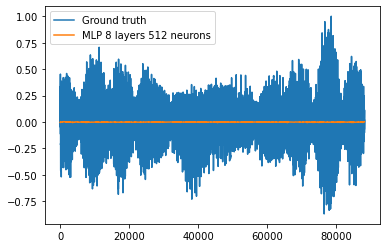

In [92]:
# Plot the reconstruction
with torch.no_grad():
    #pred_y_5_256 = mlp_audio_sin_5_256(X)
    #pred_y_8_512 = mlp_audio_sin_8_512(X)
    pred_y_3_128 = mlp_audio_sin_3_128(X)
    plt.plot(audio.cpu().numpy(), label="Ground truth")
    #plt.plot(pred_y_5_256.cpu().numpy(), label="MLP 5 layers 256 neurons")
    plt.plot(pred_y_3_128.cpu().numpy(), label="MLP 8 layers 512 neurons")
    plt.legend()


In [201]:
import pandas as pd

df = pd.DataFrame({"GT audio": audio.cpu().numpy(), 
                   "MLP 5 layers 256 neurons": pred_y_5_256.cpu().numpy().flatten(), 
                   "MLP 8 layers 512 neurons": pred_y_8_512.cpu().numpy().flatten()})

In [202]:
df.describe()

,GT audio,MLP 5 layers 256 neurons,MLP 8 layers 512 neurons
count,88200.000000,88200.000000,88200.000000
mean,0.000127,-0.013929,-0.010819
std,0.208728,0.025773,0.156109
min,-0.868308,-0.083747,-0.710084
25%,-0.130095,-0.030821,-0.116540
50%,-0.002093,-0.011080,-0.010339
75%,0.130701,0.002974,0.094733
max,1.000000,0.051832,0.658187


In [203]:
audio.shape, pred_y_8_512.shape

(torch.Size([88200]), torch.Size([88200, 1]))

In [204]:
# Play the reconstruction
Audio(pred_y_8_512.cpu().T, rate=sr)

### TODO

1. Show the gradient of the reconstructed image for different activation functions